# Filling up missing data with cluster algorithm

机器学习模型的最终效果取决于其中两个重要因素：
- 数据的质量
- 数据汇总蕴含的有用信息的数量

实际应用中，样本由于各种原因导致某些属性数据缺失，常用的处理方法是：
- 对于数值类型的数据，填充为平均值、中值等统计数值；
- 对于类别类型的数据，填充为出现次数最多的类别；

此类方法统计计算的值为全局数据集范围内，误差较大，所以考虑结合聚类算法，在某一簇内计算统计值进行填充。

## 1. Iterative EM-type algorithm


    1. Initialize missing values to their column means
    2. Repeat until convergence:
        2.1 Perform K-means clustering on the filled-in data
        2.2 Set the missing values to the centroid coordinates of the clusters to which they were assigned


### Implementation

In [1]:
import numpy as np
from sklearn.cluster import KMeans

def kmeans_missing(X, n_clusters, max_iter=10):
    """Perform K-Means clustering on data with missing values.

    Args:
      X: An [n_samples, n_features] array of data to cluster.
      n_clusters: Number of clusters to form.
      max_iter: Maximum number of EM iterations to perform.

    Returns:
      labels: An [n_samples] vector of integer labels.
      centroids: An [n_clusters, n_features] array of cluster centroids.
      X_hat: Copy of X with the missing values filled in.
    """
    # Initialize missing values to their column means
    # 非数值型、正无穷和负无穷都认为是缺失数据
    missing = ~np.isfinite(X)
    mu = np.nanmean(X, axis=0, keepdims=1)  # 忽略 NaN，计算某一列的平均值
    X_hat = np.where(missing, mu, X) # Return elements, either from x or y, depending on condition.
    X_gm = X_hat.copy()

    for i in xrange(max_iter):
        if i > 0:
            # initialize KMeans with the previous set of centroids. this is much
            # faster and makes it easier to check convergence (since labels
            # won't be permuted on every iteration), but might be more prone to
            # getting stuck in local minima.
            cls = KMeans(n_clusters, init=prev_centroids)
        else:
            # do multiple random initializations in parallel
            cls = KMeans(n_clusters, n_jobs=-1)

        # perform clustering on the filled-in data
        labels = cls.fit_predict(X_hat)
        centroids = cls.cluster_centers_

        # fill in the missing values based on their cluster centroids
        X_hat[missing] = centroids[labels][missing]

        # when the labels have stopped changing then we have converged
        if i > 0 and np.all(labels == prev_labels):
            break

        prev_labels = labels
        prev_centroids = cls.cluster_centers_

    return labels, centroids, X_hat, X_gm

### Example with fake data

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.style.use('ggplot')

from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def make_fake_data(fraction_missing, n_clusters=5, n_samples=5000,
                   n_features=3, seed=0):
    # complete data
    gen = np.random.RandomState(seed)
    X, true_labels = make_blobs(n_samples, n_features, n_clusters,
                                random_state=gen)
    # with missing values
    missing = gen.rand(*X.shape) < fraction_missing
    Xm = np.where(missing, np.nan, X)
    return X, true_labels, Xm

In [3]:
X, true_labels, Xm = make_fake_data(fraction_missing=0.1, n_clusters=6, seed=10)

In [4]:
labels, centroids, X_hat, X_gm = kmeans_missing(Xm, n_clusters=6, max_iter=40)

/home/sunnymarkliu/software/miniconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:889: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


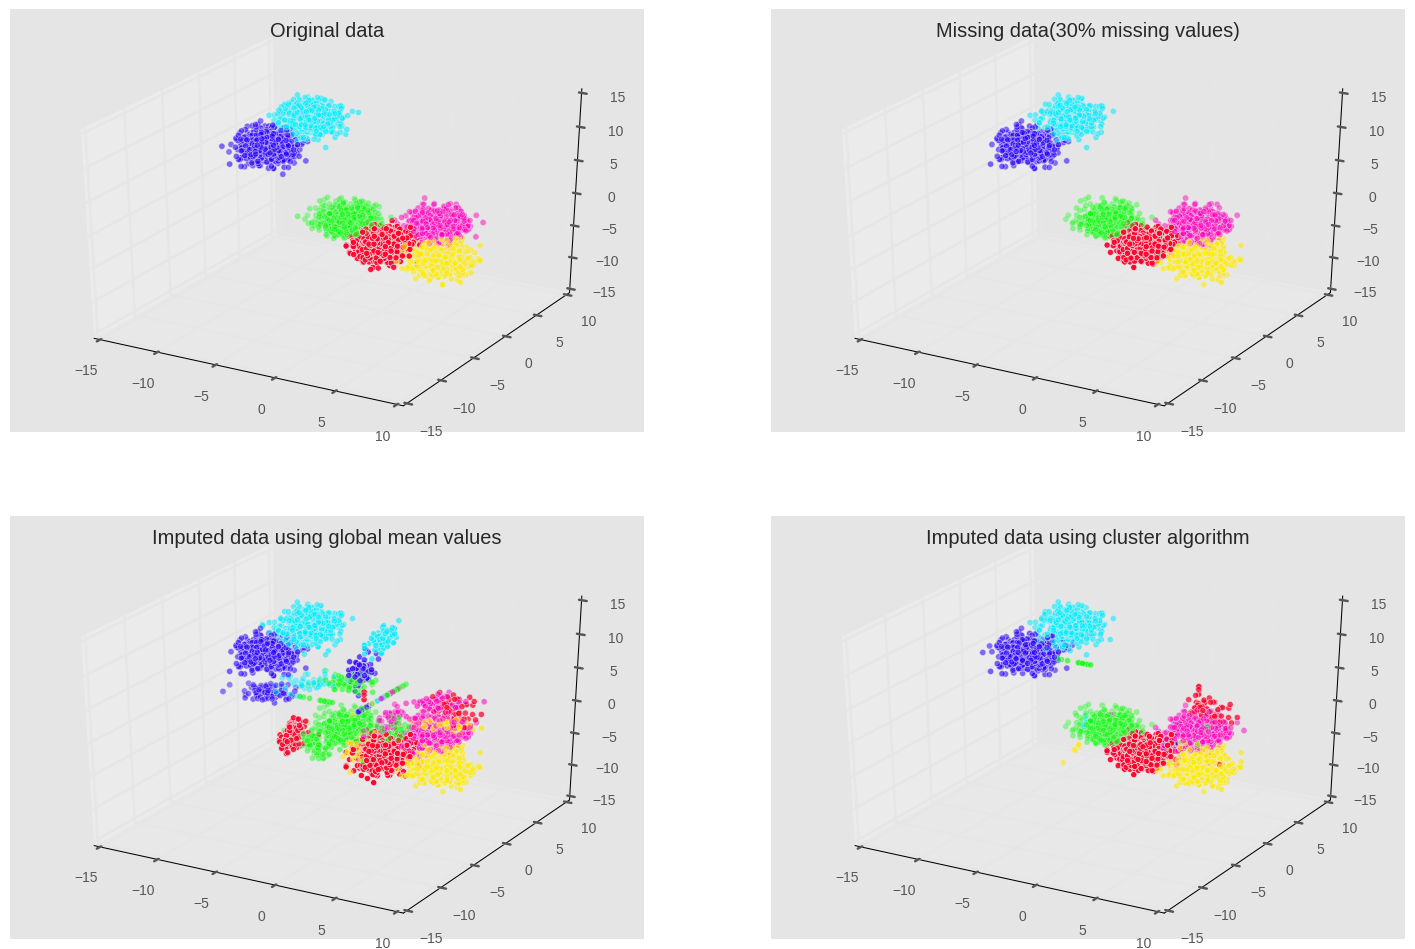

In [5]:
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(221, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=true_labels, cmap='gist_rainbow')
ax.set_title('Original data')
ax = fig.add_subplot(222, projection='3d')
ax.scatter(Xm[:, 0], Xm[:, 1], Xm[:, 2], c=true_labels, cmap='gist_rainbow')
ax.set_title('Missing data(30% missing values)')
ax = fig.add_subplot(223, projection='3d')
ax.scatter(X_gm[:, 0], X_gm[:, 1], X_gm[:, 2], c=true_labels, cmap='gist_rainbow')
ax.set_title('Imputed data using global mean values')
ax = fig.add_subplot(224, projection='3d')
ax.scatter(X_hat[:, 0], X_hat[:, 1], X_hat[:, 2], c=true_labels, cmap='gist_rainbow')
ax.set_title('Imputed data using cluster algorithm')

可以看出，采用全局平均值填充缺失值后，数据分布差别较大；相反采用聚类算法填充缺失值的效果较好。

## Performance Benchmark

The Mutual Information (互信息量) can be useful to measure the agreement of two independent label assignments strategies on the same dataset when the real ground truth is not known.

In [6]:
from sklearn.metrics import adjusted_mutual_info_score

cls = KMeans(n_clusters=5, n_jobs=-1)

true_labels = cls.fit_predict(X)
global_labels = cls.fit_predict(X_gm)
kmeans_labels = cls.fit_predict(X_hat)

print '全局平均值填充后的实际labels 与 聚类后的 labels 的互信息量：', adjusted_mutual_info_score(true_labels, global_labels)
print 'KMeans填充后的实际labels 与 聚类后的 labels 的互信息量：', adjusted_mutual_info_score(true_labels, kmeans_labels)

全局平均值填充后的实际labels 与 聚类后的 labels 的互信息量： 0.718015681753
KMeans填充后的实际labels 与 聚类后的 labels 的互信息量： 0.864182369874


可以看出：
- KMeans 算法填充后的聚类的 labels 之间的互信息量 **大于** 全局平均值填充后聚类的 labels 之间的互信息量，KMeans 填充缺失值使得原始数据的不确定性降低的更明显，验证了 KMeans 聚类填充缺失值的有效性！

(-5, 100)

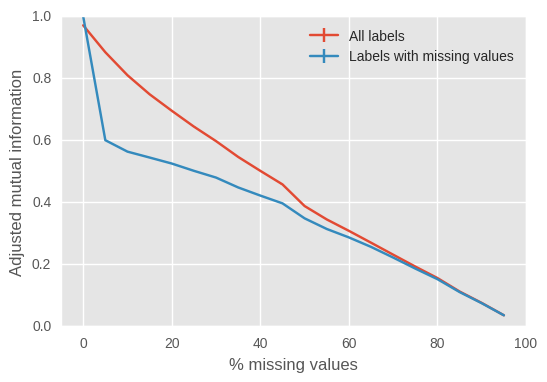

In [7]:
fraction = np.arange(0.0, 1.0, 0.05)
n_repeat = 10
scores = np.empty((2, fraction.shape[0], n_repeat))
for i, frac in enumerate(fraction):
    for j in range(n_repeat):
        X, true_labels, Xm = make_fake_data(fraction_missing=frac, n_clusters=5)
        labels, centroids, X_hat, _ = kmeans_missing(Xm, n_clusters=5)
        any_missing = np.any(~np.isfinite(Xm), 1)
        scores[0, i, j] = adjusted_mutual_info_score(labels, true_labels)
        scores[1, i, j] = adjusted_mutual_info_score(labels[any_missing],
                                                     true_labels[any_missing])

fig, ax = plt.subplots(1, 1)
scores_all, scores_missing = scores
ax.errorbar(fraction * 100, scores_all.mean(-1),
            yerr=scores_all.std(-1), label='All labels')
ax.errorbar(fraction * 100, scores_missing.mean(-1),
            yerr=scores_missing.std(-1),
            label='Labels with missing values')
ax.set_xlabel('% missing values')
ax.set_ylabel('Adjusted mutual information')
ax.legend(loc='best', frameon=False)
ax.set_ylim(0, 1)
ax.set_xlim(-5, 100)

可以看出，缺失数据越少，效果越明显。